In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv

In [2]:
BASE_DIR =Path().resolve()

In [3]:
BASE_DIR

WindowsPath('C:/Users/Dell/Desktop/semantic-image-search/semantic_image_search/notebooks')

In [4]:
images_root = BASE_DIR/"images"

In [5]:
images_root

WindowsPath('C:/Users/Dell/Desktop/semantic-image-search/semantic_image_search/notebooks/images')

In [6]:
str(images_root/"animal"/"cat.jpg")

'C:\\Users\\Dell\\Desktop\\semantic-image-search\\semantic_image_search\\notebooks\\images\\animal\\cat.jpg'

In [7]:
# Model_id = "ViT-B-32__laion2b-s34b-b79k"

In [8]:
# Model_id = "openai/clip-vit-base-patch32"

In [9]:
load_dotenv()

True

In [10]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings

In [11]:
embedding = OpenCLIPEmbeddings(
    model_name="ViT-B-32",
    checkpoint="laion2b_s34b_b79k", 
    device="cpu"
)

c:\Users\Dell\Desktop\semantic-image-search\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
img_embedding = embedding.embed_image([str(images_root/"animal"/"cat.jpeg")])

In [13]:
img_embedding

[[0.04853694513440132,
  -0.0014377229381352663,
  -0.03448808938264847,
  -0.08087947964668274,
  0.026776470243930817,
  0.07083483040332794,
  -0.008278947323560715,
  -0.048146240413188934,
  0.05869951471686363,
  0.01400085724890232,
  0.01861771196126938,
  -0.026211250573396683,
  -0.024436134845018387,
  -0.05617030709981918,
  -0.013328208588063717,
  0.025808153674006462,
  -0.12121991813182831,
  -0.02116970717906952,
  -0.010362028144299984,
  0.0012653496814891696,
  0.015890400856733322,
  -0.010824950411915779,
  -0.047347478568553925,
  -0.01107318326830864,
  -0.0681760162115097,
  -0.025547342374920845,
  -0.05428933724761009,
  0.01654183305799961,
  -0.02675372175872326,
  -0.01631147414445877,
  -0.02890767715871334,
  -0.010116596706211567,
  -0.05007088929414749,
  0.03665084019303322,
  -0.051859982311725616,
  -0.001090390607714653,
  0.003514895448461175,
  0.08354642987251282,
  -0.07093144953250885,
  -0.06484895944595337,
  0.062359295785427094,
  0.006774

In [14]:
len(img_embedding[0])

512

In [15]:
url=os.getenv("QDRANT_URL")

In [16]:
url

'https://04ed355e-553f-436d-9532-a71b1ebeea61.us-east-1-1.aws.cloud.qdrant.io:6333'

In [17]:
api_key=os.getenv("QDRANT_API_KEY")

In [19]:
#api_key

In [20]:
from qdrant_client import QdrantClient

In [21]:
qdrant_client=QdrantClient(url=url, api_key=api_key)

In [22]:
qdrant_client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='semantic-image-search')])

In [23]:
collections = qdrant_client.get_collections().collections

In [24]:
collections

[CollectionDescription(name='semantic-image-search')]

In [25]:
COLLECTION_NAME = "semantic-image-search"
VECTOR_SIZE = 512   

In [26]:
from qdrant_client.http import models

In [27]:
qdrant_client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=models.VectorParams(
        size=VECTOR_SIZE,
        distance=models.Distance.COSINE,
    )
)

UnexpectedResponse: Unexpected Response: 409 (Conflict)
Raw response content:
b'{"status":{"error":"Wrong input: Collection `semantic-image-search` already exists!"},"time":0.0236404}'

In [28]:
qdrant_client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='semantic-image-search')])

In [29]:
collections = qdrant_client.get_collections().collections
existing_names = {c.name for c in collections}

In [30]:
existing_names

{'semantic-image-search'}

In [31]:
if COLLECTION_NAME not in existing_names:
    print(f"Creating collection: {COLLECTION_NAME}")
    qdrant_client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=models.VectorParams(
            size=VECTOR_SIZE,
            distance=models.Distance.COSINE,
        ),
    )
else:
    print(f"Collection already exists: {COLLECTION_NAME} (reusing)")

Collection already exists: semantic-image-search (reusing)


In [32]:
import os
import numpy as np
from PIL import Image
from uuid import uuid4

In [33]:
def index_image(image_path,category=None):
    img_embed=embedding.embed_image([image_path])[0]
    emb=np.array(img_embed).tolist()
    
    payload = {
        "filename": os.path.basename(image_path),
        "path":image_path,
        "category": category
    }
    
    qdrant_client.upsert(
        collection_name=COLLECTION_NAME,
        points=[
            models.PointStruct(
                id=str(uuid4()),
                vector=emb,
                payload=payload
            )
        ]
    )
    print(f"Indexed → {image_path}")

In [34]:
cat_image_path=str(images_root/"animal"/"cat.jpeg")

In [35]:
cat_image_path

'C:\\Users\\Dell\\Desktop\\semantic-image-search\\semantic_image_search\\notebooks\\images\\animal\\cat.jpeg'

In [36]:
payload = {
    "filename": 'cat.jpeg',
    "path":'C:\\Users\\Dell\\Desktop\\semantic-image-search\\semantic_image_search\\notebooks\\images\\animal\\cat.jpeg',
    "category": 'animal'
}

In [37]:
index_image(cat_image_path,category="animal")

Indexed → C:\Users\Dell\Desktop\semantic-image-search\semantic_image_search\notebooks\images\animal\cat.jpeg


In [38]:
def index_folder(root_folder):
    exts = (".jpg", ".jpeg", ".png", ".webp")
    for dirpath, _, files in os.walk(root_folder):
        category = os.path.basename(dirpath)
        for f in files:
            if f.lower().endswith(exts):
                img_path = os.path.join(dirpath, f)
                #print(img_path,category)
                index_image(img_path,category=category)
    

In [39]:
index_folder("images")

Indexed → images\animal\cat.jpeg
Indexed → images\animal\crocodile.jpeg
Indexed → images\animal\crocodile_1.png
Indexed → images\animal\dog.jpeg
Indexed → images\animal\elephant.jpeg
Indexed → images\animal\giraffe.webp
Indexed → images\animal\horse.webp
Indexed → images\animal\lion.jpeg
Indexed → images\animal\panda.jpg
Indexed → images\animal\tiger.jpeg
Indexed → images\animal\zebra.jpeg
Indexed → images\flower\lavender.jpeg
Indexed → images\flower\lily.jpeg
Indexed → images\flower\lotus.jpg
Indexed → images\flower\marigold.jpeg
Indexed → images\flower\rose.jpg
Indexed → images\flower\sunflower.jpeg
Indexed → images\flower\tulip.webp
Indexed → images\furniture\table.jpeg
Indexed → images\general\bottle.jpeg
Indexed → images\general\car.webp
Indexed → images\general\chair.jpeg
Indexed → images\general\cycle.webp
Indexed → images\general\laptop.jpeg
Indexed → images\general\pen.webp
Indexed → images\general\phone.jpeg
Indexed → images\general\table.jpeg
Indexed → images\uncategorized\a

### Now lets perform the retrieval operation

#### Text --> Image retrievel

In [40]:
def search_text(query,k=5):
    results = qdrant_client.query_points(
        collection_name=COLLECTION_NAME,
        query=query,
        limit=k,
        with_payload=True,
        with_vectors=True
    )
    return results

In [41]:
query = "image of a cat with angery face"

In [42]:
query = "active crocodile"

In [43]:
query = "Yellow flower"

In [44]:
results = search_text(embedding.embed_query(query),k=3)

In [45]:
for point in results.points:
    print(point.payload, "score =", point.score)

{'filename': 'marigold.jpeg', 'path': 'images\\flower\\marigold.jpeg', 'category': 'flower'} score = 0.25321645
{'filename': 'marigold.jpeg', 'path': 'images\\flower\\marigold.jpeg', 'category': 'flower'} score = 0.25321645
{'filename': 'sunflower.jpeg', 'path': 'images\\flower\\sunflower.jpeg', 'category': 'flower'} score = 0.25297502


In [46]:
for point in results.points:
    print("Payload:", point.payload)
    print("Vector:", point.vector)
    print("Score:", point.score)

Payload: {'filename': 'marigold.jpeg', 'path': 'images\\flower\\marigold.jpeg', 'category': 'flower'}
Vector: [0.004119004, 0.0721888, -0.13287678, -0.04256982, -0.0009925129, 0.02347881, 0.011295633, 0.025497902, 0.032279205, -0.012276058, -0.0016272446, -0.028178537, 0.014875781, -0.050456036, 0.0062045474, 0.061780013, -0.07399684, -0.0071387743, 0.01240616, 0.00785931, 0.060011614, -0.007497762, 0.0098283775, 0.0074266284, -0.05346212, 0.026713522, 0.0022899983, -0.0024228184, -0.004677672, 0.028268343, -0.0052187117, 0.012984124, 0.012988162, 0.021358907, -0.016649142, -0.033417076, 0.029745549, -0.059806075, 0.030149795, 0.008705621, -0.02113798, -0.011437616, 0.021410184, -0.053751297, 0.010626018, -0.010075021, -0.033132423, -0.011922597, 0.006930019, -0.0034086548, -0.008166494, 0.063898444, -0.01481081, 0.006497718, -0.047188424, -0.10681641, -0.043505788, 0.020736037, 0.026935238, -0.016608378, -0.058877535, -0.010973992, -0.037924737, -0.0013592846, -0.023062682, 0.01876790

### Image --> Image retrieval

In [47]:
def search_by_image(image_path,k=5):
    emb = embedding.embed_image([image_path])[0]
    results = qdrant_client.query_points(
        collection_name=COLLECTION_NAME,
        query=emb,
        limit=k,
        with_payload=True
    )
    return results


In [48]:
query_image = cat_image_path

In [49]:
results= search_by_image(query_image,k=3)

In [50]:
for point in results.points:
    print(point.payload, "score =", point.score)

{'filename': 'cat.jpeg', 'path': 'images\\animal\\cat.jpeg', 'category': 'animal'} score = 1.0
{'filename': 'cat.jpeg', 'path': 'C:\\Users\\Dell\\Desktop\\semantic-image-search\\semantic_image_search\\notebooks\\images\\animal\\cat.jpeg', 'category': 'animal'} score = 1.0
{'filename': 'cat.jpeg', 'path': 'images\\animal\\cat.jpeg', 'category': 'animal'} score = 1.0


In [51]:
import os
from PIL import Image
from pathlib import Path
import shutil
import uuid

def save_retrieved_images(results, output_dir="retrieved_results"):
    output_dir = Path(output_dir) / uuid.uuid4().hex
    output_dir.mkdir(parents=True, exist_ok=True)

    for idx, point in enumerate(results.points):
        try:
            img_path = point.payload["path"]
            img = Image.open(img_path)

            save_path = output_dir / f"result_{idx}.png"
            img.save(save_path)

        except Exception as e:
            print(f"Error saving image {idx}: {e}")

    print(f"Images saved in → {output_dir}")
    return str(output_dir)


In [52]:
results

QueryResponse(points=[ScoredPoint(id='e81607c9-a398-4f13-b5c8-f4ae8401f415', version=37, score=1.0, payload={'filename': 'cat.jpeg', 'path': 'images\\animal\\cat.jpeg', 'category': 'animal'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id='83963885-e00e-47b8-8e99-09c6681724d1', version=1, score=1.0, payload={'filename': 'cat.jpeg', 'path': 'C:\\Users\\Dell\\Desktop\\semantic-image-search\\semantic_image_search\\notebooks\\images\\animal\\cat.jpeg', 'category': 'animal'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id='520140c4-020f-42b9-8f48-05ef25a5a6bc', version=2, score=1.0, payload={'filename': 'cat.jpeg', 'path': 'images\\animal\\cat.jpeg', 'category': 'animal'}, vector=None, shard_key=None, order_value=None)])

In [53]:
folder = save_retrieved_images(results)

Images saved in → retrieved_results\ba7202b7125147b2b74b755f368f0019


In [54]:
from IPython.display import display

def display_retrieved_images(results):
    for point in results.points:
        try:
            img_path = point.payload["path"]
            print("Showing →", img_path)
            display(Image.open(img_path))
        except Exception as e:
            print(f"Error displaying image: {e}")


Showing → images\animal\cat.jpeg


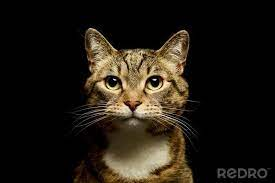

Showing → C:\Users\Dell\Desktop\semantic-image-search\semantic_image_search\notebooks\images\animal\cat.jpeg


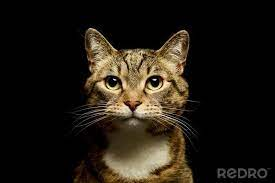

Showing → images\animal\cat.jpeg


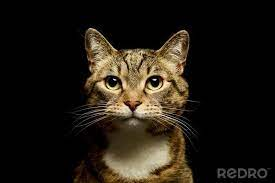

In [55]:
display_retrieved_images(results)

In [56]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate

In [57]:
from langchain_openai import ChatOpenAI

In [58]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

In [59]:
llm.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_a460d7e2b7', 'id': 'chatcmpl-CkWFKQEEOl7ts5fGKk8iAmK3Etxn6', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--77a43e57-1c7e-4fa5-89ea-b543e5ea6af4-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [60]:
TRANSLATOR_PROMPT = """
You are an expert at rewriting queries for the CLIP image–text model.

Goal:
Rewrite the user query into a short, concrete, descriptive image caption.
The rewritten query must maximize CLIP retrieval accuracy.

Guidelines:
- Keep the original meaning.
- Use 3–12 word caption style.
- Remove chat words (show me, give me, please, etc.)
- Keep colors, objects, actions.
- Translate to English if needed.
- Do NOT add new details.

User Query: {input_query}

Respond with only the rewritten caption.
"""


In [61]:
translator_prompt = PromptTemplate(
    input_variables=["input_query"],
    template=TRANSLATOR_PROMPT,
)

In [62]:
def translate_query(user_query):
    prompt = translator_prompt.format(input_query=user_query)
    response = llm.invoke(prompt)
    return response.content.strip()

In [63]:
raw_query = "Show me a picture of a very active crocodile in the water"

In [64]:
translated = translate_query(raw_query)

In [65]:
translated

'Active crocodile swimming in water.'

In [66]:
raw_query='Flower pots on a study table.'

In [67]:
raw_query = "give me flower pot images for the study table"

In [68]:
translated = translate_query(raw_query)

In [69]:
translated

'Flower pots on a study table.'

In [70]:
translated = translate_query(raw_query)
vector = embedding.embed_query(translated)
results = search_text(vector, k=3)


Showing → images\furniture\table.jpeg


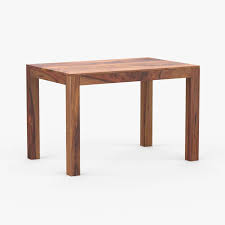

Showing → images\general\table.jpeg


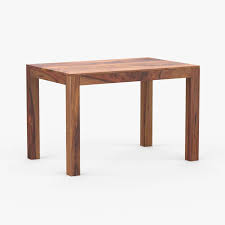

Showing → images\general\table.jpeg


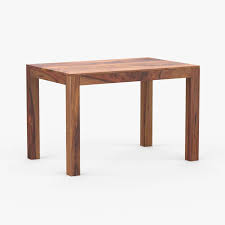

In [71]:
display_retrieved_images(results)